# Анализ данных по кредитам и платежам

Задача: проанализировать характер поведения клиентов с точки зрения просрочки платежей, выявить динамику просрочки, определить наблюдается ли рост или снижение.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('ggplot')
sns.set(font_scale=1.2)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
%matplotlib inline

## 1. Загрузка и первичный осмотр данных

In [2]:
orders = pd.read_csv('data/orders.csv', parse_dates=['created_at', 'put_at', 'closed_at'])
print(f"Количество записей в таблице orders: {orders.shape[0]}")
orders.head()

Количество записей в таблице orders: 55748


,order_id,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.00
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.00
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.00
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.00
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.00


In [3]:
plan = pd.read_csv('data/plan.csv', parse_dates=['plan_at'])
print(f"Количество записей в таблице plan: {plan.shape[0]}")
plan.head()

Количество записей в таблице plan: 420282


,order_id,plan_at,plan_sum_total
0,400001732,2022-06-02,5600.00
1,400001732,2022-07-02,9450.00
2,400001732,2022-08-01,12170.00
3,400001732,2022-08-31,14890.00
4,400001732,2022-09-30,17610.00


In [4]:
payments = pd.read_csv('data/payments.csv', parse_dates=['paid_at'])
print(f"Количество записей в таблице payments: {payments.shape[0]}")
payments.head()

Количество записей в таблице payments: 143284


,order_id,paid_at,paid_sum
0,400013633,2022-06-02 00:48:13.800,2500.00
1,400018480,2022-06-02 01:52:05.707,1070.00
2,400032001,2022-06-02 04:55:40.307,4200.00
3,400033195,2022-06-02 05:44:23.480,2850.00
4,400039407,2022-06-02 06:53:54.503,10100.00


## 2. Проверка данных на пропуски

In [64]:
print("Пропуски в таблице orders:")
print(orders.isna().sum())
print(f"Процент пропусков:\n{(orders.isna().sum() / len(orders) * 100).round(2)}")

Пропуски в таблице orders:
order_id         0
created_at       0
put_at           0
closed_at     9276
issued_sum       0
dtype: int64
Процент пропусков:
order_id      0.00
created_at    0.00
put_at        0.00
closed_at    16.64
issued_sum    0.00
dtype: float64


Пропуски в closed_at означают, что кредит еще не закрыт

In [72]:
active_loans = orders[orders['closed_at'].isna()]
print(f"Количество активных кредитов: {len(active_loans)}")
print(f"Процент активных кредитов: {len(active_loans) / len(orders) * 100:.2f}%")
active_loans.head(2)

Количество активных кредитов: 9276
Процент активных кредитов: 16.64%


,order_id,created_at,put_at,closed_at,issued_sum
31,400039450,2022-06-02 06:06:20.000,2022-06-02 17:04:46.147,NaT,8140.00
53,400087077,2022-06-02 06:49:06.997,2022-06-02 06:50:21.053,NaT,2920.00


In [73]:
closed_loans = orders[~orders['closed_at'].isna()]
print(f"Количество закрытых кредитов: {len(closed_loans)}")
print(f"Процент закрытых кредитов: {len(closed_loans) / len(orders) * 100:.2f}%")
closed_loans.head(2)

Количество закрытых кредитов: 46472
Процент закрытых кредитов: 83.36%


,order_id,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.00
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.00


In [65]:
print("Пропуски в таблице plan:")
print(plan.isna().sum())
print(f"Процент пропусков:\n{(plan.isna().sum() / len(plan) * 100).round(2)}")

Пропуски в таблице plan:
order_id          0
plan_at           0
plan_sum_total    0
dtype: int64
Процент пропусков:
order_id         0.00
plan_at          0.00
plan_sum_total   0.00
dtype: float64


In [66]:
print("Пропуски в таблице payments:")
print(payments.isna().sum())
print(f"Процент пропусков:\n{(payments.isna().sum() / len(payments) * 100).round(2)}")

Пропуски в таблице payments:
order_id    0
paid_at     0
paid_sum    0
dtype: int64
Процент пропусков:
order_id   0.00
paid_at    0.00
paid_sum   0.00
dtype: float64


## 3. Анализ типов данных и проверка соответствия

In [8]:
print("Типы данных в таблице orders:")
print(orders.dtypes)
print("\nТипы данных в таблице plan:")
print(plan.dtypes)
print("\nТипы данных в таблице payments:")
print(payments.dtypes)

Типы данных в таблице orders:
order_id               int64
created_at    datetime64[ns]
put_at        datetime64[ns]
closed_at     datetime64[ns]
issued_sum           float64
dtype: object

Типы данных в таблице plan:
order_id                   int64
plan_at           datetime64[ns]
plan_sum_total           float64
dtype: object

Типы данных в таблице payments:
order_id             int64
paid_at     datetime64[ns]
paid_sum           float64
dtype: object


## 4. Проверка на дубликаты

In [9]:
print(f"Дубликаты в таблице orders: {orders.duplicated().sum()}")
print(f"Дубликаты в таблице plan: {plan.duplicated().sum()}")
print(f"Дубликаты в таблице payments: {payments.duplicated().sum()}")

Дубликаты в таблице orders: 0
Дубликаты в таблице plan: 0
Дубликаты в таблице payments: 5


In [10]:
print("Дубликаты в таблице payments:")
print(payments[payments.duplicated()])

Дубликаты в таблице payments:
         order_id                 paid_at  paid_sum
11475   411504997 2022-06-24 17:14:56.997  10100.00
12470   422632789 2022-06-25 23:16:16.000   8080.00
37759   432761640 2022-07-21 12:38:12.000    150.00
38414   420036980 2022-07-21 20:08:58.997   4800.00
139590  456075017 2022-11-22 19:44:08.793   2720.00


In [11]:
payments[payments['order_id'] == 411504997]

,order_id,paid_at,paid_sum
11474,411504997,2022-06-24 17:14:56.997,10100.00
11475,411504997,2022-06-24 17:14:56.997,10100.00


In [12]:
payments = payments.drop_duplicates()

In [13]:
print(f"Дубликаты в таблице orders: {orders.duplicated().sum()}")
print(f"Дубликаты в таблице plan: {plan.duplicated().sum()}")
print(f"Дубликаты в таблице payments: {payments.duplicated().sum()}")

Дубликаты в таблице orders: 0
Дубликаты в таблице plan: 0
Дубликаты в таблице payments: 0


## 5. Проверка на выбросы и аномалии

In [14]:
print("Статистика по таблице orders:")
orders.describe()

Статистика по таблице orders:


,order_id,created_at,put_at,closed_at,issued_sum
count,55748.00,55748,55748,46472,55748.00
mean,447747129.81,2022-07-17 18:39:46.071710208,2022-07-20 10:34:09.089166336,2022-08-19 02:29:16.057067520,7907.20
min,400001732.00,2022-06-02 00:00:23.997000,2022-06-02 00:40:40.320000,2022-06-02 06:53:54.503000,1000.00
25%,423719467.00,2022-06-24 17:11:26.247000064,2022-06-27 18:19:40.993500160,2022-07-19 17:54:56.134500096,4000.00
50%,448009217.00,2022-07-17 18:42:36,2022-07-20 18:03:11.164999936,2022-08-15 20:33:26.241999872,7290.00
75%,471668525.25,2022-08-09 14:34:08.499249920,2022-08-11 20:32:59.392749824,2022-09-12 06:44:54.682500096,10850.00
max,495177509.00,2022-08-31 23:49:42.997000,2022-09-29 18:46:58.387000,2022-12-08 09:48:38.233000,28570.00
std,27553910.02,NaN,NaN,NaN,4985.85


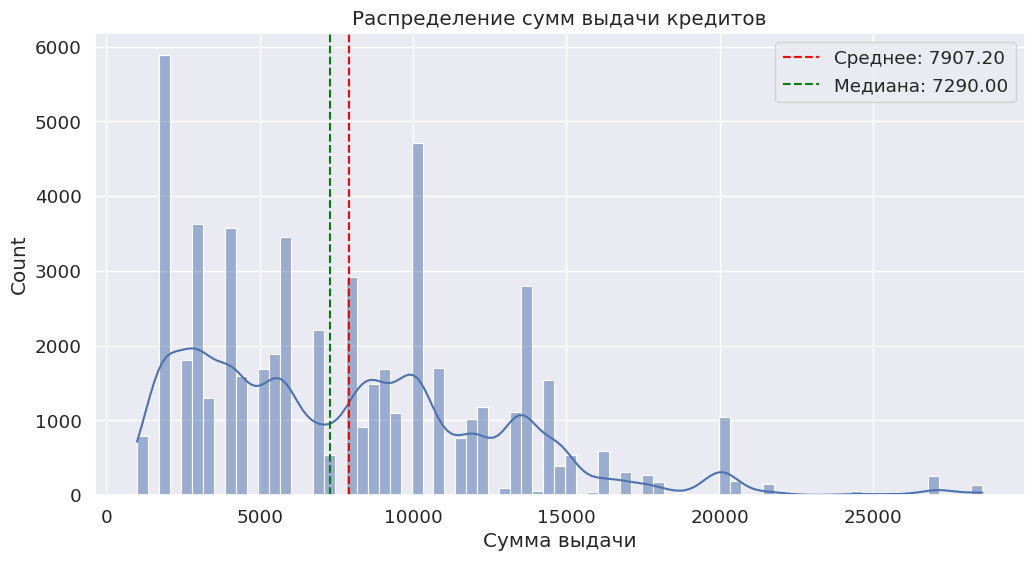

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(orders['issued_sum'].dropna(), kde=True)
plt.title('Распределение сумм выдачи кредитов')
plt.xlabel('Сумма выдачи')
plt.axvline(orders['issued_sum'].mean(), color='red', linestyle='--', label=f'Среднее: {orders["issued_sum"].mean():.2f}')
plt.axvline(orders['issued_sum'].median(), color='green', linestyle='--', label=f'Медиана: {orders["issued_sum"].median():.2f}')
plt.legend()
plt.show()

In [16]:
print("Статистика по таблице plan:")
plan.describe()

Статистика по таблице plan:


,order_id,plan_at,plan_sum_total
count,420282.00,420282,420282.00
mean,447898223.84,2022-10-10 12:39:00.691249920,8662.57
min,400001732.00,2022-06-02 00:00:00,0.00
25%,423702834.00,2022-08-22 00:00:00,3570.00
50%,448097668.00,2022-10-09 00:00:00,6900.00
75%,472030326.00,2022-11-29 00:00:00,12158.47
max,495177509.00,2023-06-11 00:00:00,2300000.00
std,27568987.19,NaN,10951.91


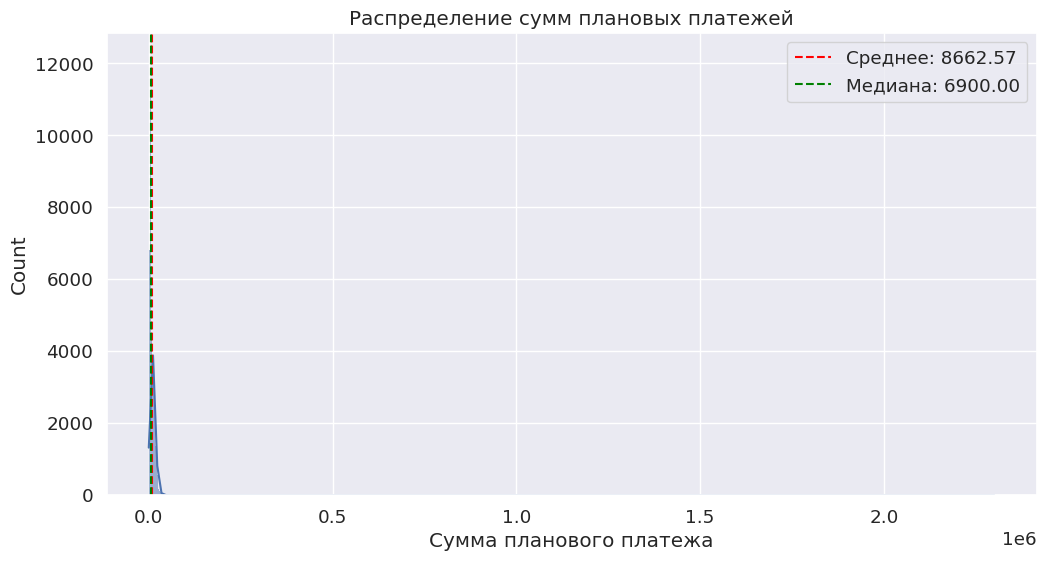

In [17]:
plt.figure(figsize=(12, 6))
sns.histplot(plan['plan_sum_total'].dropna(), kde=True)
plt.title('Распределение сумм плановых платежей')
plt.xlabel('Сумма планового платежа')
plt.axvline(plan['plan_sum_total'].mean(), color='red', linestyle='--', label=f'Среднее: {plan["plan_sum_total"].mean():.2f}')
plt.axvline(plan['plan_sum_total'].median(), color='green', linestyle='--', label=f'Медиана: {plan["plan_sum_total"].median():.2f}')
plt.legend()
plt.show()

In [18]:
print("Статистика по таблице payments:")
payments.describe()

Статистика по таблице payments:


,order_id,paid_at,paid_sum
count,143279.00,143279,143279.00
mean,447151206.94,2022-08-21 00:38:27.878156800,3902.70
min,400001732.00,2022-06-02 00:48:13.800000,0.02
25%,423182852.00,2022-07-19 15:49:03.251500032,1039.70
50%,447085478.00,2022-08-16 23:36:16.689999872,2125.60
75%,470738379.00,2022-09-15 17:48:14.293500160,4600.00
max,495177509.00,2022-12-08 13:28:23.703000,49469.37
std,27425918.75,NaN,4528.16


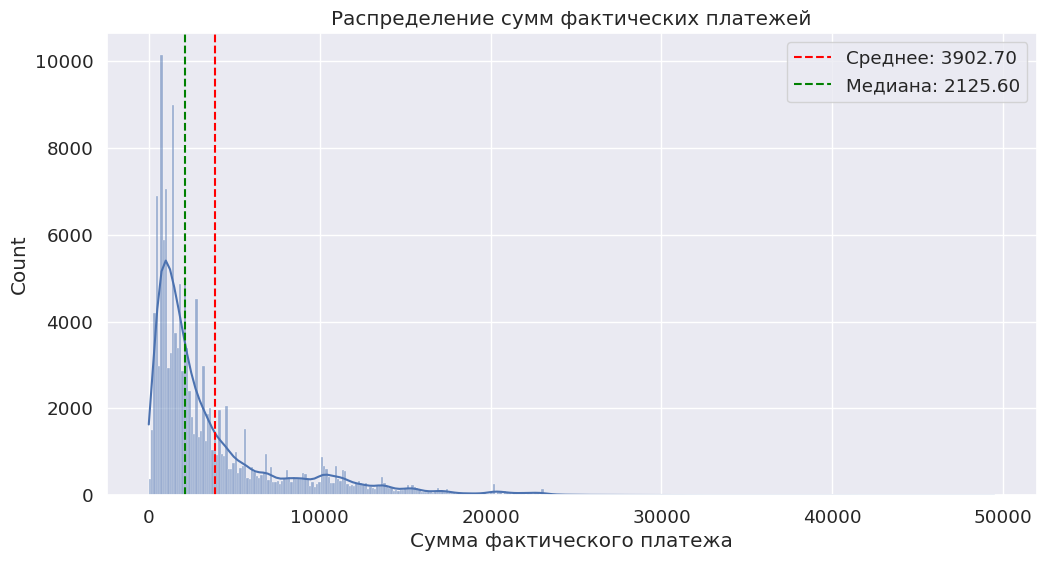

In [19]:
plt.figure(figsize=(12, 6))
sns.histplot(payments['paid_sum'].dropna(), kde=True)
plt.title('Распределение сумм фактических платежей')
plt.xlabel('Сумма фактического платежа')
plt.axvline(payments['paid_sum'].mean(), color='red', linestyle='--', label=f'Среднее: {payments["paid_sum"].mean():.2f}')
plt.axvline(payments['paid_sum'].median(), color='green', linestyle='--', label=f'Медиана: {payments["paid_sum"].median():.2f}')
plt.legend()
plt.show()

### 5.1 Анализ числовых переменных с помощью боксплотов

Построим боксплоты для основных числовых переменных, чтобы визуализировать их распределение и выявить возможные выбросы.

In [20]:
def plot_boxplot(data, column, title, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    sns.boxplot(x=data[column])
    plt.title(title, fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    print(f"Минимум: {data[column].min():.2f}")
    print(f"1-й квартиль (25%): {data[column].quantile(0.25):.2f}")
    print(f"Медиана (50%): {data[column].quantile(0.5):.2f}")
    print(f"3-й квартиль (75%): {data[column].quantile(0.75):.2f}")
    print(f"Максимум: {data[column].max():.2f}")
    print(f"Среднее: {data[column].mean():.2f}")
    print(f"Стандартное отклонение: {data[column].std():.2f}")
    
    # Определение выбросов по методу межквартильного размаха (IQR)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column]
    
    print(f"\nМежквартильный размах (IQR): {IQR:.2f}")
    print(f"Нижняя граница для выбросов: {lower_bound:.2f}")
    print(f"Верхняя граница для выбросов: {upper_bound:.2f}")
    print(f"Количество выбросов: {len(outliers)}")
    print(f"Процент выбросов: {100 * len(outliers) / len(data):.2f}%")

    if len(outliers) > 0:
        print("\nРаспределение выбросов:")
        print(outliers.describe())

In [21]:
def remove_outliers(data, column, multiplier=1.5, inplace=False, verbose=True):
    if not inplace:
        data_cleaned = data.copy()
    else:
        data_cleaned = data
    
    Q1 = data_cleaned[column].quantile(0.25)
    Q3 = data_cleaned[column].quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    # Находим индексы выбросов
    outlier_indices = data_cleaned[(data_cleaned[column] < lower_bound) | 
                                   (data_cleaned[column] > upper_bound)].index
    
    n_outliers = len(outlier_indices)
    data_cleaned.drop(outlier_indices, inplace=True)

    if verbose:
        print(f"Анализ выбросов в столбце '{column}':")
        print(f"Нижняя граница: {lower_bound:.2f}")
        print(f"Верхняя граница: {upper_bound:.2f}")
        print(f"Удалено записей: {n_outliers} ({100 * n_outliers / len(data):.2f}% от исходных данных)")
        print(f"Осталось записей: {len(data_cleaned)}")
    
    return data_cleaned

#### 5.1.1 Анализ суммы выдачи (issued_sum)

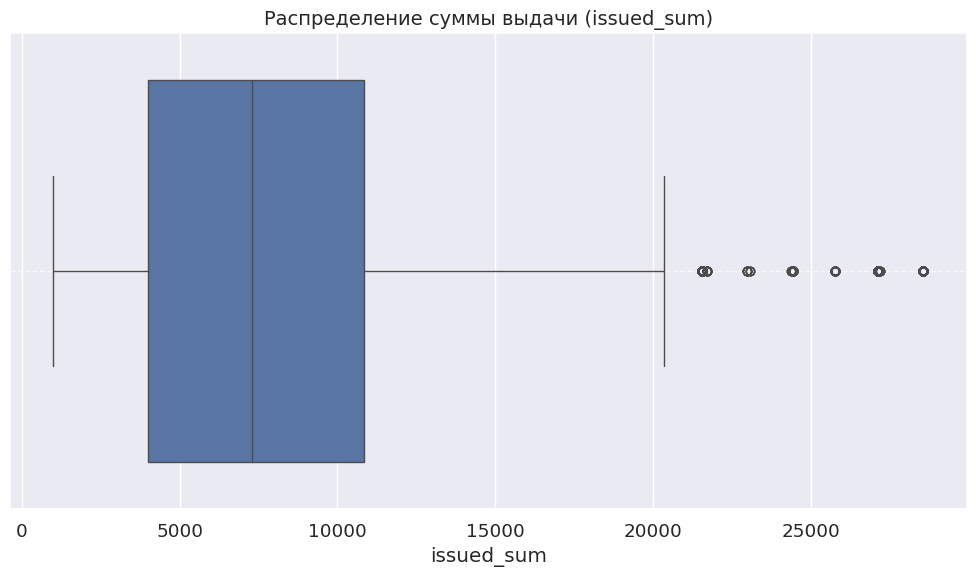

Минимум: 1000.00
1-й квартиль (25%): 4000.00
Медиана (50%): 7290.00
3-й квартиль (75%): 10850.00
Максимум: 28570.00
Среднее: 7907.20
Стандартное отклонение: 4985.85

Межквартильный размах (IQR): 6850.00
Нижняя граница для выбросов: -6275.00
Верхняя граница для выбросов: 21125.00
Количество выбросов: 674
Процент выбросов: 1.21%

Распределение выбросов:
count     674.00
mean    25696.91
std      2574.61
min     21550.00
25%     23410.00
50%     27130.00
75%     27130.00
max     28570.00
Name: issued_sum, dtype: float64


In [22]:
plot_boxplot(orders, 'issued_sum', 'Распределение суммы выдачи (issued_sum)')

In [ ]:
# orders = remove_outliers(orders, 'issued_sum')

#### 5.1.2 Анализ сумм плановых платежей (plan_sum_total)

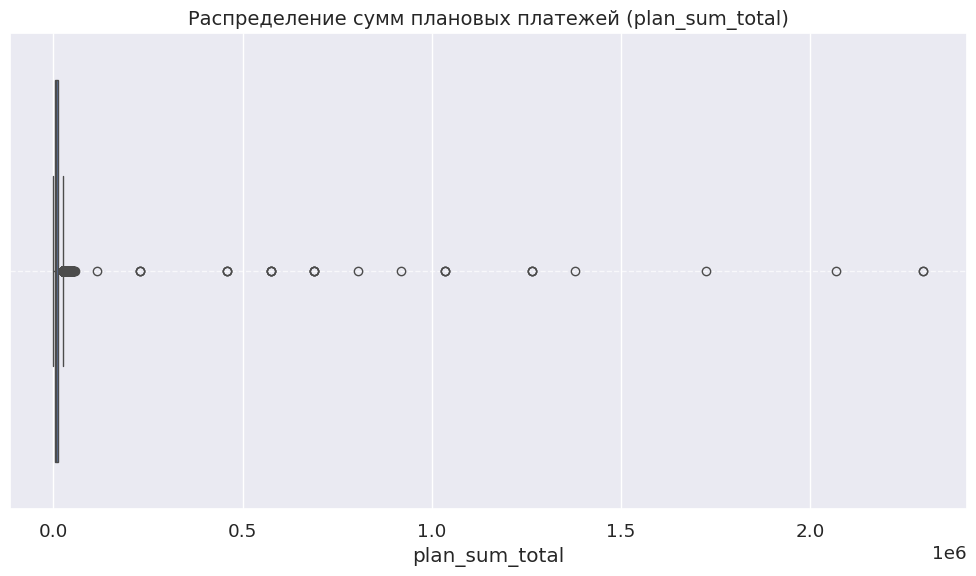

Минимум: 0.00
1-й квартиль (25%): 3570.00
Медиана (50%): 6900.00
3-й квартиль (75%): 12158.47
Максимум: 2300000.00
Среднее: 8662.57
Стандартное отклонение: 10951.91

Межквартильный размах (IQR): 8588.47
Нижняя граница для выбросов: -9312.70
Верхняя граница для выбросов: 25041.17
Количество выбросов: 7846
Процент выбросов: 1.87%

Распределение выбросов:
count      7846.00
mean      34150.81
std       63743.51
min       25041.35
25%       26574.45
50%       29152.35
75%       34211.04
max     2300000.00
Name: plan_sum_total, dtype: float64


In [24]:
plot_boxplot(plan, 'plan_sum_total', 'Распределение сумм плановых платежей (plan_sum_total)')

В данных о плановых платежах присутствует небольшое количество выбросов (1.87%), но они значительно отклоняются от основной массы данных. Максимальное значение 2.300.000 намного превышает медиану 6.900.

In [25]:
# plan = remove_outliers(plan, 'plan_sum_total')

#### 5.1.3 Анализ сумм фактических платежей (paid_sum)

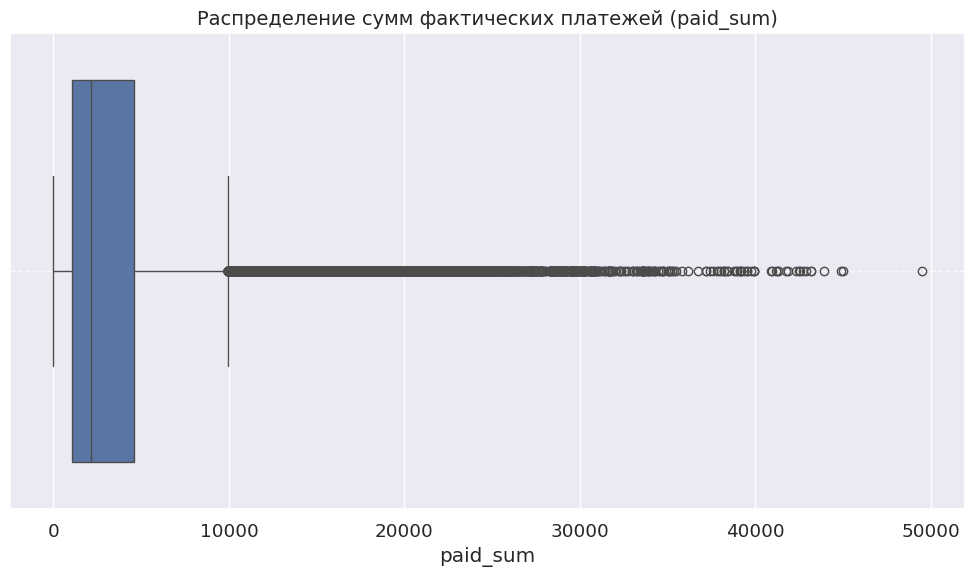

Минимум: 0.02
1-й квартиль (25%): 1039.70
Медиана (50%): 2125.60
3-й квартиль (75%): 4600.00
Максимум: 49469.37
Среднее: 3902.70
Стандартное отклонение: 4528.16

Межквартильный размах (IQR): 3560.30
Нижняя граница для выбросов: -4300.75
Верхняя граница для выбросов: 9940.45
Количество выбросов: 16535
Процент выбросов: 11.54%

Распределение выбросов:
count   16535.00
mean    14275.67
std      4459.62
min      9942.39
25%     11043.40
50%     12771.80
75%     15900.00
max     49469.37
Name: paid_sum, dtype: float64


In [26]:
plot_boxplot(payments[payments['paid_sum'].notnull()], 'paid_sum', 'Распределение сумм фактических платежей (paid_sum)')

В данных о плановых платежах присутствует небольшое количество выбросов (1.87%), но они значительно отклоняются от основной массы данных. Максимальное значение 49469.37 намного превышает медиану 2125.60.

In [ ]:
# payments = remove_outliers(payments, 'paid_sum')

### 5.2 Анализ отклонений между плановыми и фактическими платежами

Рассчитаем разницу между плановыми и фактическими платежами, чтобы выявить потенциальные аномалии.

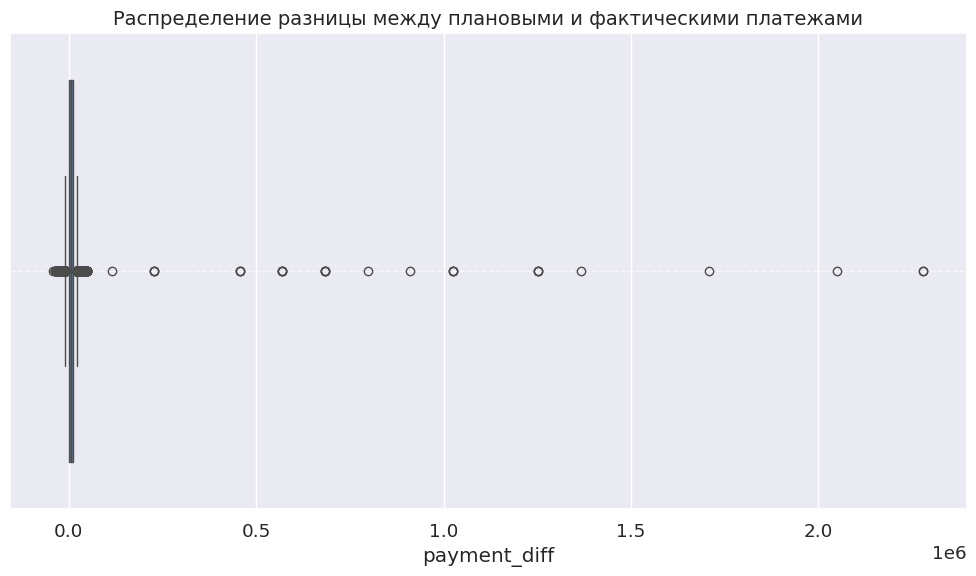

Минимум: -40899.37
1-й квартиль (25%): 1503.38
Медиана (50%): 4691.85
3-й квартиль (75%): 10080.00
Максимум: 2279800.00
Среднее: 6128.13
Стандартное отклонение: 8389.56

Межквартильный размах (IQR): 8576.62
Нижняя граница для выбросов: -11361.55
Верхняя граница для выбросов: 22944.93
Количество выбросов: 32315
Процент выбросов: 2.20%

Распределение выбросов:
count     32315.00
mean      20747.07
std       36141.96
min      -40899.37
25%       23207.84
50%       25503.70
75%       30381.28
max     2279800.00
Name: payment_diff, dtype: float64


In [57]:
payments_with_both = payments[payments['paid_sum'].notnull()].merge(
    plan[['order_id', 'plan_sum_total']], 
    on='order_id',
    how='inner'
)

payments_with_both['payment_diff'] = payments_with_both['plan_sum_total'] - payments_with_both['paid_sum']

plot_boxplot(
    payments_with_both, 
    'payment_diff', 
    'Распределение разницы между плановыми и фактическими платежами'
)

### 5.3 Анализ просрочек по времени

Рассчитаем разницу между датой планового платежа и датой фактического платежа, чтобы оценить просрочку во времени.

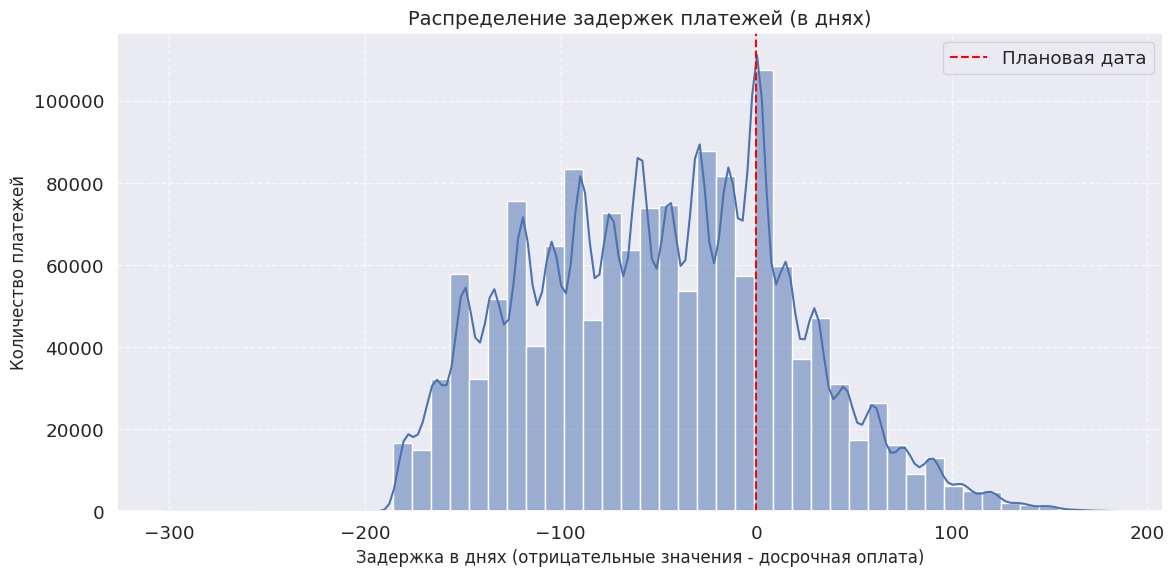

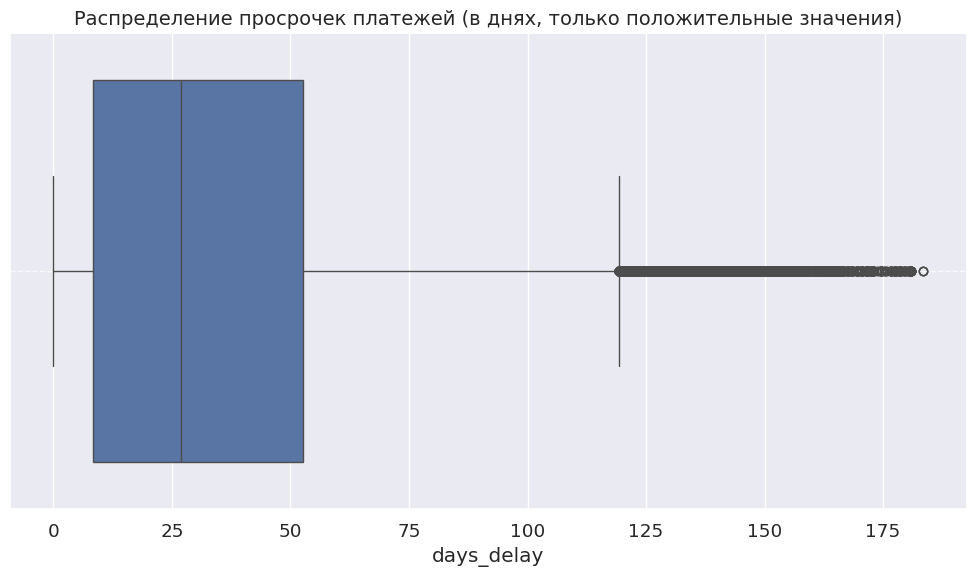


Доля просроченных платежей: 25.40%

Экстремальные просрочки (более 119.3 дней): 8624 платежей
Это составляет 0.59% от всех платежей


In [61]:
time_diff_data = payments[payments['paid_at'].notnull()].merge(
    plan[['order_id', 'plan_at']], 
    on='order_id', 
    how='inner'
)

time_diff_data['days_delay'] = (time_diff_data['paid_at'] - time_diff_data['plan_at']).dt.total_seconds() / (24 * 3600)

plt.figure(figsize=(12, 6))
sns.histplot(data=time_diff_data, x='days_delay', bins=50, kde=True)
plt.axvline(x=0, color='red', linestyle='--', label='Плановая дата')
plt.title('Распределение задержек платежей (в днях)', fontsize=14)
plt.xlabel('Задержка в днях (отрицательные значения - досрочная оплата)', fontsize=12)
plt.ylabel('Количество платежей', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

overdue_payments = time_diff_data[time_diff_data['days_delay'] > 0]

plt.figure(figsize=(10, 6))
sns.boxplot(data=overdue_payments, x='days_delay')
plt.title('Распределение просрочек платежей (в днях, только положительные значения)', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Q1 = overdue_payments['days_delay'].quantile(0.25)
Q3 = overdue_payments['days_delay'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

extreme_delays = overdue_payments[overdue_payments['days_delay'] > upper_bound]

print(f"\nДоля просроченных платежей: {100 * len(overdue_payments) / len(time_diff_data):.2f}%")
print(f"\nЭкстремальные просрочки (более {upper_bound:.1f} дней): {len(extreme_delays)} платежей")
print(f"Это составляет {100 * len(extreme_delays) / len(time_diff_data):.2f}% от всех платежей")

### 5.4 Выводы по анализу выбросов и аномалий

1. **Суммы выдач (issued_sum)**: В данных присутствуют выбросы по суммам выдач, но они согласуются с бизнес-логикой кредитования, так как максимальные значения отражают большие кредиты, которые выдаются отдельным клиентам.

2. **Плановые и фактические платежи**: Распределение сумм как плановых, так и фактических платежей имеет выбросы, что может быть связано с вариативностью графиков погашения у разных клиентов.

3. **Разница между плановыми и фактическими платежами**: Наблюдаются как положительные, так и отрицательные выбросы, что указывает на случаи значительной недоплаты или переплаты по сравнению с планом.

4. **Просрочки по времени**: Анализ временных задержек выявил значительную долю просроченных платежей, а также наличие экстремальных задержек у части клиентов.

## 6. Проверка временных рядов и периодов

In [30]:
print("Временной диапазон заявок:")
print(f"Самая ранняя дата создания: {orders['created_at'].min()}")
print(f"Самая поздняя дата создания: {orders['created_at'].max()}")

print("\nВременной диапазон плановых платежей:")
print(f"Самая ранняя дата платежа: {plan['plan_at'].min()}")
print(f"Самая поздняя дата платежа: {plan['plan_at'].max()}")

print("\nВременной диапазон фактических платежей:")
print(f"Самая ранняя дата платежа: {payments['paid_at'].min()}")
print(f"Самая поздняя дата платежа: {payments['paid_at'].max()}")

Временной диапазон заявок:
Самая ранняя дата создания: 2022-06-02 00:00:23.997000
Самая поздняя дата создания: 2022-08-31 23:49:42.997000

Временной диапазон плановых платежей:
Самая ранняя дата платежа: 2022-06-02 00:00:00
Самая поздняя дата платежа: 2023-06-11 00:00:00

Временной диапазон фактических платежей:
Самая ранняя дата платежа: 2022-06-02 00:48:13.800000
Самая поздняя дата платежа: 2022-12-08 13:28:23.703000


### Выводы
   - Заявки создавались только в течение 3 месяцев (с начала июня по конец августа 2022 года)
   - Плановые платежи запланированы до июня 2023 года (на год вперед)


## 7. Подготовка данных и анализ просрочек

In [41]:
cutoff_date = pd.Timestamp('2022-12-08')

total_plan_payments = len(plan)

plan_filtered = plan[plan['plan_at'] <= cutoff_date].copy()

valid_plan_payments = len(plan_filtered)
invalid_plan_payments = total_plan_payments - valid_plan_payments

print(f"Всего плановых платежей: {total_plan_payments}")
print(f"Плановых платежей до 08.12.2022: {valid_plan_payments}")
print(f"Плановых платежей после 08.12.2022: {invalid_plan_payments}")
print(f"Процент плановых платежей, которые можно включить в анализ просрочек: {100 * valid_plan_payments / total_plan_payments:.2f}%")

Всего плановых платежей: 420282
Плановых платежей до 08.12.2022: 333399
Плановых платежей после 08.12.2022: 86883
Процент плановых платежей, которые можно включить в анализ просрочек: 79.33%


In [42]:
plan_analysis = plan_filtered.copy()

plan_orders = pd.merge(plan_analysis, orders, on='order_id', how='left')
plan_orders.head()

,order_id,plan_at,plan_sum_total,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02,5600.00,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.00
1,400001732,2022-07-02,9450.00,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.00
2,400001732,2022-08-01,12170.00,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.00
3,400001732,2022-08-31,14890.00,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.00
4,400001732,2022-09-30,17610.00,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.00


In [43]:
# Группируем фактические платежи по order_id и дате платежа,
# чтобы получить суммарный платеж по каждой заявке на каждую дату
payments_grouped = payments.groupby(['order_id', 'paid_at'])['paid_sum'].sum().reset_index()
payments_grouped.head()

,order_id,paid_at,paid_sum
0,400001732,2022-06-02 20:20:16.790,5600.00
1,400001732,2022-06-16 16:05:26.007,3850.00
2,400001732,2022-07-15 12:32:34.087,2720.00
3,400001732,2022-08-16 12:38:01.237,2720.00
4,400001732,2022-09-15 12:14:48.867,2720.00


Для каждого планового платежа найдем соответствующие фактические платежи

In [ ]:
def analyze_payment(row, payments_df):
    order_id = row['order_id']
    plan_date = row['plan_at']
    plan_sum = row['plan_sum_total']
    
    # Отбираем все фактические платежи по этой заявке до текущей даты планового платежа включительно
    # (для расчета накопленной суммы платежей)
    relevant_payments = payments_df[(payments_df['order_id'] == order_id) & 
                                    (payments_df['paid_at'] <= pd.Timestamp(plan_date) + pd.Timedelta(days=1))]
    
    total_paid = relevant_payments['paid_sum'].sum() if not relevant_payments.empty else 0
    
    # Определяем, был ли платеж просрочен
    # Если сумма фактических платежей меньше плановой, считаем это просрочкой
    is_overdue = total_paid < plan_sum
    
    # Рассчитываем сумму недоплаты
    overdue_amount = max(0, plan_sum - total_paid)
    
    return pd.Series([total_paid, is_overdue, overdue_amount], 
                     index=['total_paid', 'is_overdue', 'overdue_amount'])

plan_analysis[['total_paid', 'is_overdue', 'overdue_amount']] = plan_analysis.apply(
    lambda row: analyze_payment(row, payments_grouped), axis=1)

plan_analysis.head()

,order_id,plan_at,plan_sum_total,total_paid,is_overdue,overdue_amount
0,400001732,2022-06-02,5600.00,5600.00,False,0.00
1,400001732,2022-07-02,9450.00,9450.00,False,0.00
2,400001732,2022-08-01,12170.00,12170.00,False,0.00
3,400001732,2022-08-31,14890.00,14890.00,False,0.00
4,400001732,2022-09-30,17610.00,20330.00,False,0.00


## 8. Анализ динамики просрочек во времени

In [45]:
plan_analysis['month'] = plan_analysis['plan_at'].dt.to_period('M')

# Рассчитываем долю просроченных платежей по месяцам
monthly_overdue = plan_analysis.groupby('month').agg(
    total_payments=('is_overdue', 'count'),
    overdue_payments=('is_overdue', 'sum'),
    overdue_amount=('overdue_amount', 'sum')
).reset_index()

monthly_overdue['overdue_rate'] = monthly_overdue['overdue_payments'] / monthly_overdue['total_payments'] * 100

monthly_overdue.head()

,month,total_payments,overdue_payments,overdue_amount,overdue_rate
0,2022-06,17980,7266,19439561.84,40.41
1,2022-07,44342,20469,68710797.34,46.16
2,2022-08,66450,27356,72170108.51,41.17
3,2022-09,65135,22968,77202131.13,35.26
4,2022-10,62951,15462,74628895.11,24.56


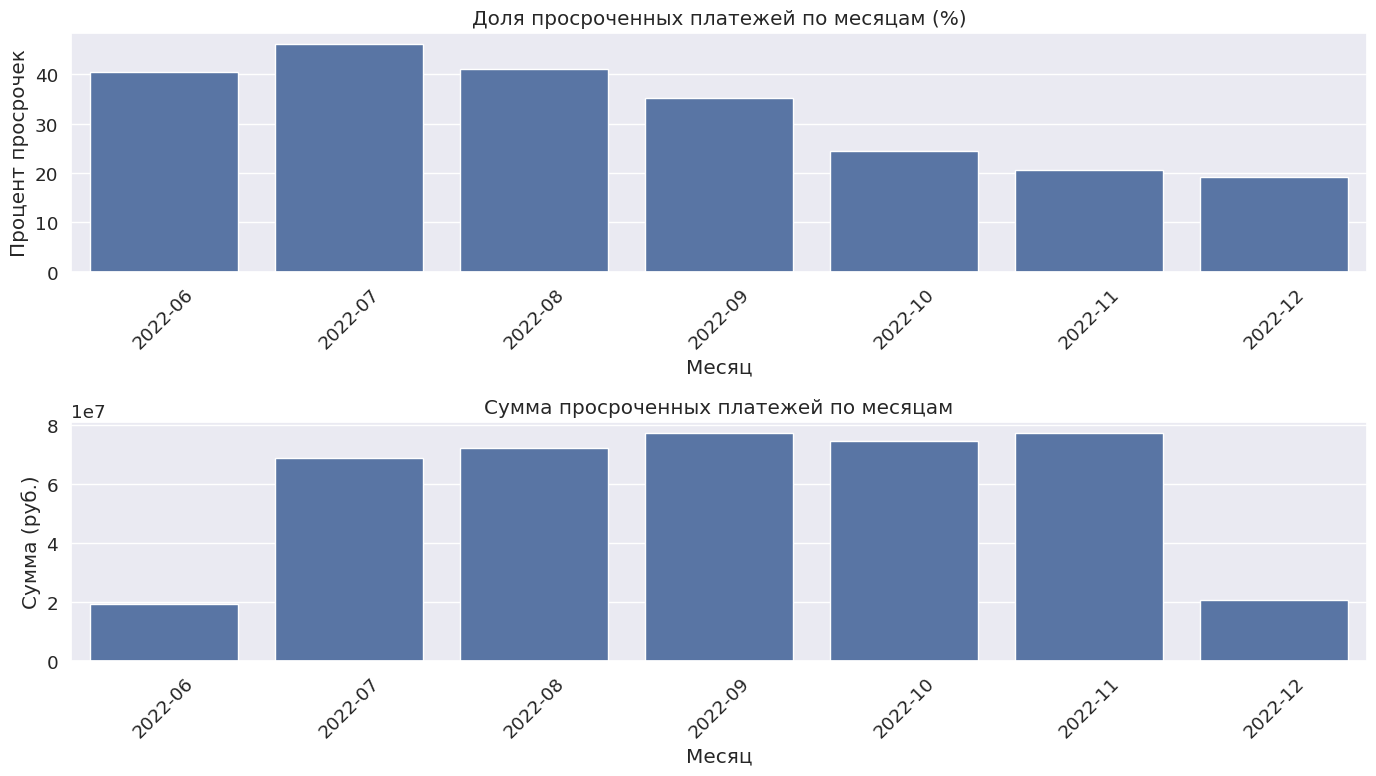

In [46]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
sns.barplot(x=monthly_overdue['month'].astype(str), y='overdue_rate', data=monthly_overdue)
plt.title('Доля просроченных платежей по месяцам (%)')
plt.xticks(rotation=45)
plt.xlabel('Месяц')
plt.ylabel('Процент просрочек')

plt.subplot(2, 1, 2)
sns.barplot(x=monthly_overdue['month'].astype(str), y='overdue_amount', data=monthly_overdue)
plt.title('Сумма просроченных платежей по месяцам')
plt.xticks(rotation=45)
plt.xlabel('Месяц')
plt.ylabel('Сумма (руб.)')

plt.tight_layout()
plt.show()

## 9. Анализ распределения размера просрочек

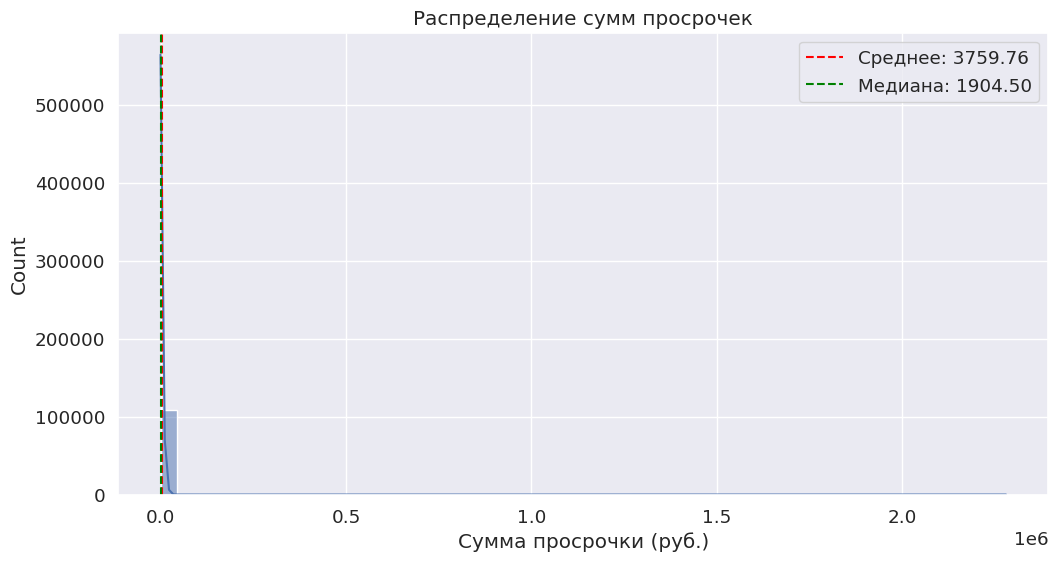

In [47]:
overdue_only = plan_analysis[plan_analysis['is_overdue'] == True]

plt.figure(figsize=(12, 6))
sns.histplot(overdue_only['overdue_amount'], kde=True, bins=50)
plt.title('Распределение сумм просрочек')
plt.xlabel('Сумма просрочки (руб.)')
plt.axvline(overdue_only['overdue_amount'].mean(), color='red', linestyle='--', 
            label=f'Среднее: {overdue_only["overdue_amount"].mean():.2f}')
plt.axvline(overdue_only['overdue_amount'].median(), color='green', linestyle='--', 
            label=f'Медиана: {overdue_only["overdue_amount"].median():.2f}')
plt.legend()
plt.show()

## 10. Сегментация кредитов по уровню просрочки

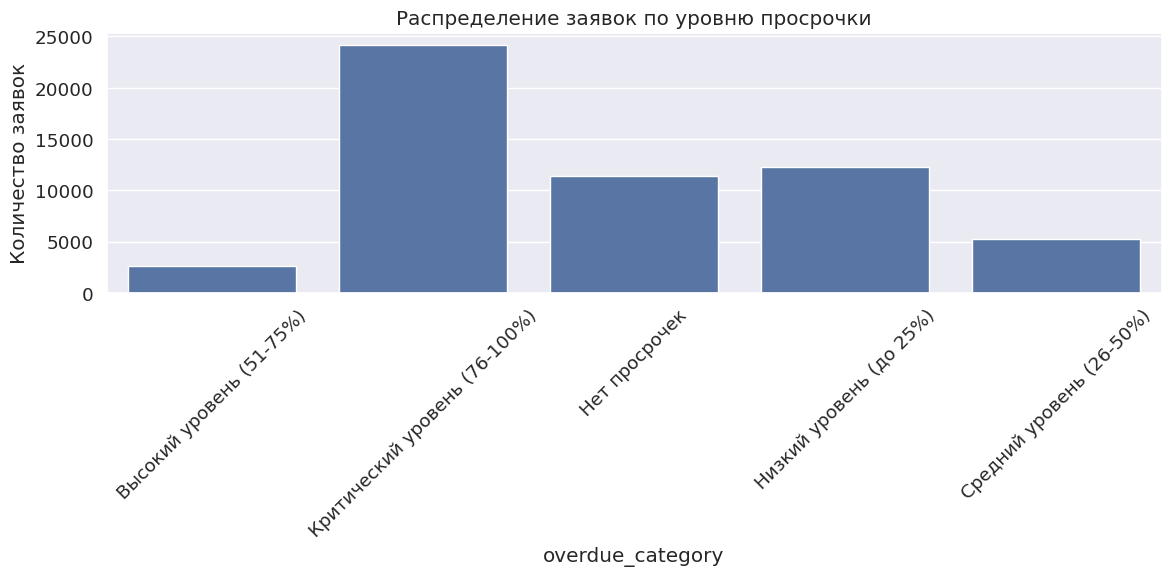

In [48]:
# Рассчитываем долю просроченных платежей для каждой заявки
order_overdue = plan_analysis.groupby('order_id').agg(
    total_payments=('is_overdue', 'count'),
    overdue_payments=('is_overdue', 'sum'),
    total_overdue_amount=('overdue_amount', 'sum')
).reset_index()

order_overdue['overdue_rate'] = order_overdue['overdue_payments'] / order_overdue['total_payments'] * 100

def categorize_overdue(rate):
    if rate == 0:
        return 'Нет просрочек'
    elif rate <= 25:
        return 'Низкий уровень (до 25%)'
    elif rate <= 50:
        return 'Средний уровень (26-50%)'
    elif rate <= 75:
        return 'Высокий уровень (51-75%)'
    else:
        return 'Критический уровень (76-100%)'

order_overdue['overdue_category'] = order_overdue['overdue_rate'].apply(categorize_overdue)

category_counts = order_overdue['overdue_category'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Распределение заявок по уровню просрочки')
plt.ylabel('Количество заявок')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 11. Динамика новых просрочек

Анализ появления новых просрочек по месяцам

Количество новых просрочек по месяцам:
month
2022-06     6227
2022-07    14037
2022-08    15000
2022-09     7551
2022-10     1070
2022-11      351
2022-12       69
Freq: M, Name: count, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

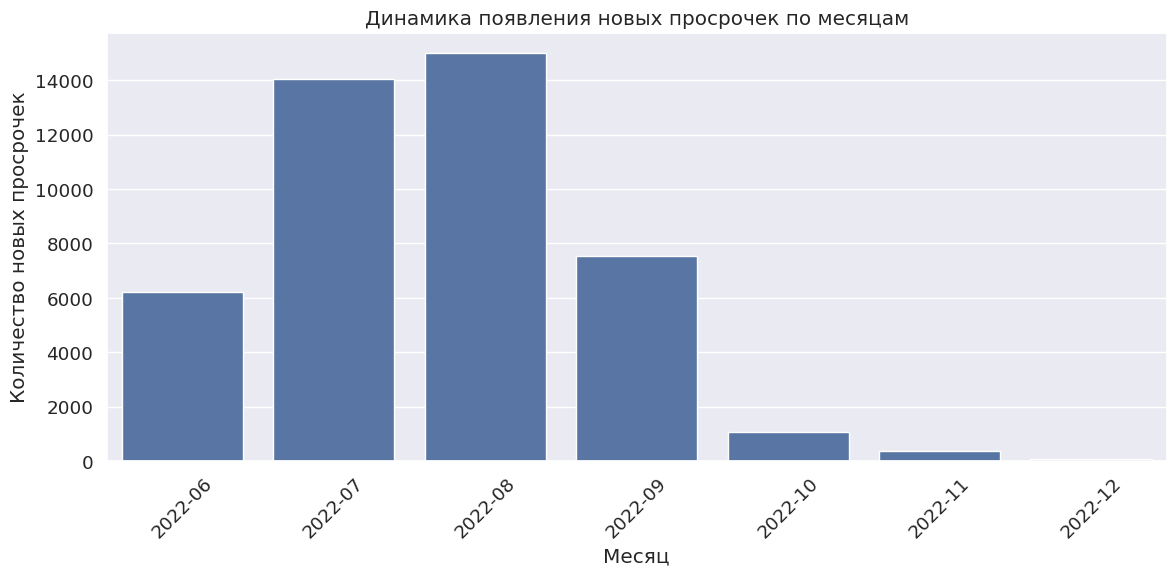

In [ ]:
first_overdue = (
    plan_analysis[plan_analysis["is_overdue"]]
    .groupby("order_id")["plan_at"]
    .min()
    .reset_index()
)
first_overdue["month"] = first_overdue["plan_at"].dt.to_period("M")

new_overdue_by_month = first_overdue["month"].value_counts().sort_index()
print("Количество новых просрочек по месяцам:")
print(new_overdue_by_month)

plt.figure(figsize=(12, 6))
sns.barplot(x=new_overdue_by_month.index.astype(str), y=new_overdue_by_month.values)
plt.title("Динамика появления новых просрочек по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Количество новых просрочек")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show

## 12. Выводы по результатам анализа

In [50]:
total_plans = len(plan_analysis)
total_overdue = plan_analysis["is_overdue"].sum()
overdue_rate = total_overdue / total_plans * 100

print(f"Общее количество плановых платежей: {total_plans}")
print(f"Общее количество просроченных платежей: {total_overdue}")
print(f"Общая доля просроченных платежей: {overdue_rate:.2f}%")
print(f"Общая сумма просрочек: {plan_analysis['overdue_amount'].sum():.2f} руб.")

# Анализ тренда просрочек (рост/снижение)
if len(monthly_overdue) > 1:
    first_month_rate = monthly_overdue.iloc[0]["overdue_rate"]
    last_month_rate = monthly_overdue.iloc[-1]["overdue_rate"]
    rate_change = last_month_rate - first_month_rate

    print(
        f"\nДоля просрочек в первом месяце анализа ({monthly_overdue.iloc[0]['month']}): {first_month_rate:.2f}%"
    )
    print(
        f"Доля просрочек в последнем месяце анализа ({monthly_overdue.iloc[-1]['month']}): {last_month_rate:.2f}%"
    )

    if rate_change > 0:
        print(
            f"Наблюдается РОСТ доли просрочек на {rate_change:.2f} процентных пунктов"
        )
    elif rate_change < 0:
        print(
            f"Наблюдается СНИЖЕНИЕ доли просрочек на {abs(rate_change):.2f} процентных пунктов"
        )
    else:
        print("Доля просрочек осталась неизменной")

    # Линейная регрессия для оценки тренда
    x = np.arange(len(monthly_overdue))
    y = monthly_overdue["overdue_rate"].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    print(f"\nКоэффициент наклона линейного тренда: {slope:.4f}")
    if p_value < 0.05:
        trend_direction = "рост" if slope > 0 else "снижение"
        print(
            f"Тренд статистически значим (p-value: {p_value:.4f}) и показывает {trend_direction} просрочек"
        )
    else:
        print(f"Тренд статистически не значим (p-value: {p_value:.4f})")

Общее количество плановых платежей: 333399
Общее количество просроченных платежей: 109034
Общая доля просроченных платежей: 32.70%
Общая сумма просрочек: 409941619.46 руб.

Доля просрочек в первом месяце анализа (2022-06): 40.41%
Доля просрочек в последнем месяце анализа (2022-12): 19.23%
Наблюдается СНИЖЕНИЕ доли просрочек на 21.18 процентных пунктов

Коэффициент наклона линейного тренда: -4.6927
Тренд статистически значим (p-value: 0.0025) и показывает снижение просрочек


Формирование небольшого отчета в txt (если надо)

In [63]:
with open("analysis_conclusions.txt", "w", encoding="utf-8") as f:
    f.write("АНАЛИЗ ДАННЫХ ПО КРЕДИТАМ И ПЛАТЕЖАМ\n")
    f.write("=" * 50 + "\n\n")

    f.write("ОСНОВНЫЕ ПОКАЗАТЕЛИ:\n")
    f.write(f"- Общее количество плановых платежей: {total_plans}\n")
    f.write(f"- Общее количество просроченных платежей: {total_overdue}\n")
    f.write(f"- Общая доля просроченных платежей: {overdue_rate:.2f}%\n")
    f.write(
        f"- Общая сумма просрочек: {plan_analysis['overdue_amount'].sum():.2f} руб.\n\n"
    )

    f.write("ДИНАМИКА ПРОСРОЧЕК:\n")
    if len(monthly_overdue) > 1:
        f.write(
            f"- Доля просрочек в первом месяце анализа ({monthly_overdue.iloc[0]['month']}): {first_month_rate:.2f}%\n"
        )
        f.write(
            f"- Доля просрочек в последнем месяце анализа ({monthly_overdue.iloc[-1]['month']}): {last_month_rate:.2f}%\n"
        )

        if rate_change > 0:
            f.write(
                f"- Наблюдается РОСТ доли просрочек на {rate_change:.2f} процентных пунктов\n"
            )
        elif rate_change < 0:
            f.write(
                f"- Наблюдается СНИЖЕНИЕ доли просрочек на {abs(rate_change):.2f} процентных пунктов\n"
            )
        else:
            f.write("- Доля просрочек осталась неизменной\n")

        f.write(f"- Коэффициент наклона линейного тренда: {slope:.4f}\n")
        if p_value < 0.05:
            trend_direction = "рост" if slope > 0 else "снижение"
            f.write(
                f"- Тренд статистически значим (p-value: {p_value:.4f}) и показывает {trend_direction} просрочек\n\n"
            )
        else:
            f.write(f"- Тренд статистически не значим (p-value: {p_value:.4f})\n\n")

    f.write("СЕГМЕНТАЦИЯ КРЕДИТОВ ПО УРОВНЮ ПРОСРОЧКИ:\n")
    for category, count in category_counts.items():
        percentage = count / len(order_overdue) * 100
        f.write(f"- {category}: {count} заявок ({percentage:.2f}%)\n")

## 13. Выводы

1. Масштаб проблемы:
   - Почти каждый третий платеж (32.70%) совершается с просрочкой, что указывает на значительные проблемы с платежной дисциплиной;
   - Общая сумма просрочек превышает 409.9 млн рублей;
   - 43.36% заявок находятся в зоне критического риска (76-100% просроченных платежей).

2. Положительная динамика:
   - Наблюдается устойчивое СНИЖЕНИЕ доли просрочек с 40.41% в июне 2022 до 19.23% в декабре 2022;
   - Снижение составило 21.18% за анализируемый период (более чем в 2 раза);
   - Отрицательный коэффициент наклона линейного тренда (-4.6927) является статистически значимым (p-value: 0.0025), что подтверждает устойчивость тенденции к снижению.

3. Структура кредитного портфеля:
   - Только пятая часть заявок (20.53%) не имеет просрочек;
   - Группа низкого риска (без просрочек + низкий уровень просрочек) составляет 42.51%;
   - Группа высокого риска (высокий + критический уровень просрочек) составляет 48.09%;
   - Это говорит, что клиенты либо платят хорошо, либо очень плохо.

4. Оценка эффективности мер:
   - Значительное снижение доли просрочек (с 40.41% до 19.23%) свидетельствует об эффективности принятых ранее мер по работе с должниками;
   - Заметное улучшение ситуации произошло во второй половине 2022 года, что может свидетельствовать о внедрении новых подходов к взысканию.

5. Проблемные зоны:
   - Концентрация 43.36% заявок в зоне критического риска требует особого внимания и специализированных мер воздействия;

## 14. Рекомендации

1. Продолжить реализацию мер, обеспечивших значительное снижение доли просрочек во второй половине 2022 года;

2. Разработка разных подходов к работе с различными сегментами должников:
   - Для заявок с критическим уровнем просрочки (43.36%): разработать специальную программу реструктуризации и интенсифицировать работу по взысканию;
   - Для заявок со средним и высоким уровнем просрочки (14.13%): предложить гибкие условия погашения и программы финансового оздоровления;
   - Для заявок с низким уровнем просрочки (21.98%): усилить систему напоминаний и разработать программу стимулирования своевременных платежей;

3. Внедрение системы раннего предупреждения просрочек на основе предиктивной аналитики;

4. Пересмотр скоринговой модели с учетом выявленных факторов риска;

5. Внедрение сезонных стратегий для снижения риска просрочек в периоды повышенной финансовой нагрузки;

6. Разработка программы финансовой грамотности для клиентов с целью профилактики просрочек;

7. Внедрение многоуровневой системы мониторинга просрочек платежей клиентов, которая позволит оперативно реагировать на риски неплатежей и снизить вероятность финансовых потерь компании:

   - На первом уровне настроить автоматическое уведомление сотрудников о небольших просрочках для своевременного контакта с клиентом и предотвращения ухудшения ситуации;
   - На втором уровне будет создан отдельный аналитический дашборд для управления крупными просрочками. Это позволит руководителям быстро оценивать масштабы рисков, отслеживать динамику просроченных платежей и принимать обоснованные управленческие решения.